**Imports**

In [1]:
import os 
import math
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

**Load**

In [2]:
all_submissions = []
defog_ids = [fname.split('.')[0] for fname in os.listdir('/kaggle/input/test-data')] # Get defog ids from test directory

**Configuration model 1**

In [3]:
CFG = {'TPU': 0,
       'block_size': 12096, 
       'block_stride': 12096//16,
       'patch_size': 14, 
       'fog_model_dim': 320,
       'fog_model_num_heads': 6,
       'fog_model_num_encoder_layers': 5,
       'fog_model_num_lstm_layers': 2,
       'fog_model_first_dropout': 0.1,
       'fog_model_encoder_dropout': 0.1,
       'fog_model_mha_dropout': 0.0,
      }
assert CFG['block_size'] % CFG['patch_size'] == 0
assert CFG['block_size'] % CFG['block_stride'] == 0

def sample_normalize(sample):
    mean = tf.math.reduce_mean(sample)
    std = tf.math.reduce_std(sample)
    sample = tf.math.divide_no_nan(sample-mean, std)
    return sample.numpy()

def get_blocks(series, columns):
    series = series.copy()
    series = series[columns]
    series = series.values
    series = series.astype(np.float32)    
    block_count = math.ceil(len(series) / CFG['block_size'])
    series = np.pad(series, pad_width=[[0, block_count*CFG['block_size']-len(series)], [0, 0]])
    block_begins = list(range(0, len(series), CFG['block_stride']))
    block_begins = [x for x in block_begins if x+CFG['block_size'] <= len(series)]
    blocks = []
    for begin in block_begins:
        values = series[begin:begin+CFG['block_size']]
        blocks.append({'begin': begin,
                       'end': begin+CFG['block_size'],
                       'values': values})
    return blocks

GPU_BATCH_SIZE = 4

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=CFG['fog_model_num_heads'], key_dim=CFG['fog_model_dim'], dropout=CFG['fog_model_mha_dropout'])
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.seq = tf.keras.Sequential([tf.keras.layers.Dense(CFG['fog_model_dim'], activation='relu'), 
                                        tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']), 
                                        tf.keras.layers.Dense(CFG['fog_model_dim']), 
                                        tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']),
                                       ])    
    def call(self, x):
        attn_output = self.mha(query=x, key=x, value=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)
        return x

class FOGEncoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.first_linear = tf.keras.layers.Dense(CFG['fog_model_dim'])       
        self.add = tf.keras.layers.Add()    
        self.first_dropout = tf.keras.layers.Dropout(CFG['fog_model_first_dropout'])  
        self.enc_layers = [EncoderLayer() for _ in range(CFG['fog_model_num_encoder_layers'])]    
        self.lstm_layers = [tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(CFG['fog_model_dim'], return_sequences=True)) for _ in range(CFG['fog_model_num_lstm_layers'])]     
        self.sequence_len = CFG['block_size'] // CFG['patch_size']
        self.pos_encoding = tf.Variable(initial_value=tf.random.normal(shape=(1, self.sequence_len, CFG['fog_model_dim']), stddev=0.02), trainable=True)     
    def call(self, x, training=None): # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (4, 864, 42)
        x = x / 50.0 # Normalization attempt in the segment [-1, 1]
        x = self.first_linear(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (4, 864, 320)       
        if training: # augmentation by randomly roll of the position encoding tensor
            random_pos_encoding = tf.roll(tf.tile(self.pos_encoding, multiples=[GPU_BATCH_SIZE, 1, 1]), 
                                          shift=tf.random.uniform(shape=(GPU_BATCH_SIZE,), minval=-self.sequence_len, maxval=0, dtype=tf.int32),
                                          axis=GPU_BATCH_SIZE * [1],
                                          )
            x = self.add([x, random_pos_encoding])  
        else: # without augmentation 
            x = self.add([x, tf.tile(self.pos_encoding, multiples=[GPU_BATCH_SIZE, 1, 1])])          
        x = self.first_dropout(x)      
        for i in range(CFG['fog_model_num_encoder_layers']): x = self.enc_layers[i](x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (4, 864, 320)
        for i in range(CFG['fog_model_num_lstm_layers']): x = self.lstm_layers[i](x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (4, 864, 640)           
        return x
    
class FOGModel(tf.keras.Model):
    def __init__(self):
        super().__init__()     
        self.encoder = FOGEncoder()
        self.last_linear = tf.keras.layers.Dense(4)      
    def call(self, x): # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (4, 864, 42)
        x = self.encoder(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (4, 864, 640)
        x = self.last_linear(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], 3), Example shape (4, 864, 4)
        x = tf.nn.sigmoid(x) # Sigmoid activation      
        return x

In [4]:
class PredictionFnCallback(tf.keras.callbacks.Callback):
    def __init__(self, prediction_ids, model=None, verbose=0):       
        if not model is None: self.model = model
        self.verbose = verbose       
        def init(Id, path):
            series = pd.read_csv(path).reset_index(drop=True)
            series['Id'] = Id
            series['AccV'] = sample_normalize(series['AccV'].values)
            series['AccML'] = sample_normalize(series['AccML'].values)
            series['AccAP'] = sample_normalize(series['AccAP'].values)           
            series_blocks=[]
            for block in get_blocks(series, ['AccV', 'AccML', 'AccAP']): # Example shape (12096, 3)
                values = tf.reshape(block['values'], shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size'], 3)) # Example shape (864, 14, 3)
                values = tf.reshape(values, shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3)) # Example shape (864, 42)
                values = tf.expand_dims(values, axis=0) # Example shape (1, 864, 42)               
                self.blocks.append(values)
                series_blocks.append((self.blocks_counter, block['begin'], block['end']))
                self.blocks_counter += 1         
            description = {}
            description['series'] = series
            description['series_blocks'] = series_blocks
            self.descriptions.append(description)           
        self.descriptions = [] # Blocks metadata
        self.blocks = [] # Test data blocks
        self.blocks_counter=0 # Blocks counter              
        defog_ids = prediction_ids
        defog_paths = [f'/kaggle/input/test-data/{defog_id}.csv' for defog_id in defog_ids]
        for defog_id, defog_path in tqdm(zip(defog_ids, defog_paths), total=len(defog_ids), desc='PredictionFnCallback Initialization', disable=1-verbose): 
            init(defog_id, defog_path)              
        self.blocks = tf.concat(self.blocks, axis=0)  # Example shape (self.blocks_counter, 864, 42)  
        self.blocks = tf.pad(self.blocks, 
                             paddings=[[0, math.ceil(self.blocks_counter / (GPU_BATCH_SIZE))*(GPU_BATCH_SIZE)-self.blocks_counter], 
                                                    [0, 0], 
                                                    [0, 0],
                                      ]) # Example shape (self.blocks_counter+pad_value, 864, 42)     
        print(f'\n[PredictionFnCallback Initialization] [Series] {len(self.descriptions)} [Blocks] {self.blocks_counter}\n')  
    def prediction(self):
        predictions = model.predict(self.blocks, batch_size=GPU_BATCH_SIZE, verbose=self.verbose) # Example shape (self.blocks_counter+pad_value, 864, 4)
        predictions = predictions[:, :, :3] # Example shape (self.blocks_counter+pad_value, 864, 3)
        predictions = tf.expand_dims(predictions, axis=-1) # Example shape (self.blocks_counter+pad_value, 864, 3, 1)
        predictions = tf.transpose(predictions, perm=[0, 1, 3, 2]) # Example shape (self.blocks_counter+pad_value, 864, 1, 3)
        predictions = tf.tile(predictions, multiples=[1, 1, CFG['patch_size'], 1]) # Example shape (self.blocks_counter+pad_value, 864, 14, 3)
        predictions = tf.reshape(predictions, shape=(predictions.shape[0], predictions.shape[1]*predictions.shape[2], 3)) # Example shape (self.blocks_counter+pad_value, 12096, 3)
        predictions = predictions.numpy()
        def create_target(description):
            series, series_blocks = description['series'].copy(), description['series_blocks']       
            values = np.zeros((series_blocks[-1][2], 4))
            for series_block in series_blocks:
                i, begin, end = series_block
                values[begin:end, 0:3] += predictions[i]
                values[begin:end, 3] += 1
            values = values[:len(series)]            
            series['StartHesitation_prediction'] = values[:, 0] / values[:, 3]
            series['Turn_prediction'] = values[:, 1] / values[:, 3]
            series['Walking_prediction'] = values[:, 2] / values[:, 3]
            series['Prediction_count'] = values[:, 3]          
            return series        
        targets = Parallel(n_jobs=-1)(delayed(create_target)(self.descriptions[i]) for i in tqdm(range(len(self.descriptions)), disable=1-self.verbose))
        targets = pd.concat(targets).reset_index(drop=True)    
        return targets
    
WEIGHTS = '/kaggle/input/saved-models/034_0.432_0.800_0.0351_model.h5'

model = FOGModel()
model.build(input_shape=(GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3))
if len(WEIGHTS): 
    model.load_weights(WEIGHTS)
for Id in defog_ids:
    targets = PredictionFnCallback(prediction_ids=[Id], model=model).prediction()
    submission = pd.DataFrame({'Id': (targets['Id'].values + '_' + targets['Time'].astype('str')).values,
                               'StartHesitation': targets['StartHesitation_prediction'].values,
                               'Turn': targets['Turn_prediction'].values,
                               'Walking': targets['Walking_prediction'].values,
                              })
    all_submissions.append(submission)


[PredictionFnCallback Initialization] [Series] 1 [Blocks] 289



**Configuration model 2**
Train data: defog data (100%)
Validation data: notype data (100%)

In [5]:
CFG = {'TPU': 0,
       'block_size': 12096, 
       'block_stride': 12096//16,
       'patch_size': 14, 
       'batch_size': 16,
       
       'fog_model_dim': 320,
       'fog_model_num_heads': 6,
       'fog_model_num_encoder_layers': 4,
       'fog_model_num_lstm_layers': 2,
       'fog_model_first_dropout': 0.1,
       'fog_model_encoder_dropout': 0.1,
       'fog_model_mha_dropout': 0.0,
      }

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=CFG['fog_model_num_heads'], key_dim=CFG['fog_model_dim'])       
        self.add = tf.keras.layers.Add()   
        self.layernorm = tf.keras.layers.LayerNormalization()      
        self.seq = tf.keras.Sequential([tf.keras.layers.Dense(CFG['fog_model_dim'], activation='relu'), 
                                        tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']), 
                                        tf.keras.layers.Dense(CFG['fog_model_dim']), 
                                        tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']),
                                       ])      
    def call(self, x):
        attn_output, attn_scores = self.mha(query=x, key=x, value=x, 
                                            return_attention_scores=True)   
        self.attn_scores = attn_scores   
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)        
        return x

class FOGEncoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.masking = tf.keras.layers.Masking()      
        self.first_linear = tf.keras.layers.Dense(CFG['fog_model_dim'])        
        self.add = tf.keras.layers.Add()        
        self.first_dropout = tf.keras.layers.Dropout(CFG['fog_model_first_dropout'])        
        self.enc_layers = [EncoderLayer() for _ in range(CFG['fog_model_num_encoder_layers'])]        
        self.lstm_layers = [tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(CFG['fog_model_dim'], return_sequences=True)) for _ in range(CFG['fog_model_num_lstm_layers'])]        
        self.sequence_len = CFG['block_size'] // CFG['patch_size']
        self.pos_encoding = tf.Variable(initial_value=tf.random.normal(shape=(1, self.sequence_len, CFG['fog_model_dim']), stddev=0.02), trainable=True)        
    def call(self, x, training=None): # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (16, 864, 42)
        x = x / 50.0 # Normalization attempt in the segment [0, 1]
        x = self.masking(x) # Masks a padded timesteps from multi head attention and lstm layers
        x = self.first_linear(x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (16, 864, 320)         
        x = self.add([x, tf.tile(self.pos_encoding, multiples=[CFG['batch_size'], 1, 1])])         
        x = self.first_dropout(x)        
        km = x._keras_mask # Bug fix (Multi head attention masking does not work on TPU training)
        del x._keras_mask # Bug fix 
        for i in range(CFG['fog_model_num_encoder_layers']): x = self.enc_layers[i](x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (16, 864, 320)
        x._keras_mask = km # Bug fix
        for i in range(CFG['fog_model_num_lstm_layers']): x = self.lstm_layers[i](x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (16, 864, 640)            
        return x
    
class FOGModel(tf.keras.Model):
    def __init__(self):
        super().__init__()     
        self.encoder = FOGEncoder()
        self.last_linear = tf.keras.layers.Dense(3)        
    def call(self, x): # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (16, 864, 42)
        x = self.encoder(x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (16, 864, 640)
        x = self.last_linear(x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], 3), Example shape (16, 864, 3)
        x = tf.nn.sigmoid(x) # Sigmoid activation     
        return x

In [6]:
class PredictionFnCallback(tf.keras.callbacks.Callback):
    def __init__(self, prediction_ids, model=None, verbose=0):      
        if not model is None: self.model = model
        self.verbose = verbose        
        def init(Id, path):
            series = pd.read_csv(path).reset_index(drop=True)
            series['Id'] = Id
            series['AccV'] = sample_normalize(series['AccV'].values)
            series['AccML'] = sample_normalize(series['AccML'].values)
            series['AccAP'] = sample_normalize(series['AccAP'].values)         
            series_blocks=[]
            for block in get_blocks(series, ['AccV', 'AccML', 'AccAP']): # Example shape (12096, 3)
                values = tf.reshape(block['values'], shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size'], 3)) # Example shape (864, 14, 3)
                values = tf.reshape(values, shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3)) # Example shape (864, 42)
                values = tf.concat([values, 
                                    tf.constant(1.0, dtype=tf.float32, shape=(CFG['block_size'] // CFG['patch_size'], 1)),
                                   ], axis=-1) # Example shape (864, 43) (Add a constant to the right. Not used. Has no effect on the model)
                values = tf.expand_dims(values, axis=0) # Example shape (1, 864, 43)            
                self.blocks.append(values)
                series_blocks.append((self.blocks_counter, block['begin'], block['end']))
                self.blocks_counter += 1        
            description = {}
            description['series'] = series
            description['series_blocks'] = series_blocks
            self.descriptions.append(description)       
        self.descriptions = [] # Blocks metadata
        self.blocks = [] # Test data blocks
        self.blocks_counter=0 # Blocks counter     
        notype_ids = prediction_ids
        notype_paths = [f'/kaggle/input/test-data/{notype_id}.csv' for notype_id in notype_ids]
        for notype_id, notype_path in tqdm(zip(notype_ids, notype_paths), total=len(notype_ids), desc='PredictionFnCallback Initialization', disable=1-verbose): 
            init(notype_id, notype_path)       
        self.blocks = tf.concat(self.blocks, axis=0) # Example shape (self.blocks_counter, 864, 42)
        self.blocks = tf.pad(self.blocks, 
                             paddings=[[0, math.ceil(self.blocks_counter / CFG['batch_size'])*CFG['batch_size']-self.blocks_counter], 
                                                    [0, 0], 
                                                    [0, 0],
                                      ]) # Example shape (self.blocks_counter+pad_value, 864, 42)
        print(f'[PredictionFnCallback Initialization] [Series] {len(self.descriptions)} [Blocks] {self.blocks_counter}') 
    def prediction(self):
        predictions = model.predict(self.blocks, batch_size=CFG['batch_size'], verbose=self.verbose) # Example shape (self.blocks_counter+pad_value, 864, 3)
        predictions = tf.expand_dims(predictions, axis=-1) # Example shape (self.blocks_counter+pad_value, 864, 3, 1)
        predictions = tf.transpose(predictions, perm=[0, 1, 3, 2]) # Example shape (self.blocks_counter+pad_value, 864, 1, 3)
        predictions = tf.tile(predictions, multiples=[1, 1, CFG['patch_size'], 1]) # Example shape (self.blocks_counter+pad_value, 864, 14, 3)
        predictions = tf.reshape(predictions, shape=(predictions.shape[0], predictions.shape[1]*predictions.shape[2], 3)) # Example shape (self.blocks_counter+pad_value, 12096, 3)
        predictions = predictions.numpy() 
        def create_target(description):
            series, series_blocks = description['series'].copy(), description['series_blocks']
            values = np.zeros((series_blocks[-1][2], 4))
            for series_block in series_blocks:
                i, begin, end = series_block
                values[begin:end, 0:3] += predictions[i]
                values[begin:end, 3] += 1
            values = values[:len(series)]     
            series['StartHesitation_prediction'] = values[:, 0] / values[:, 3]
            series['Turn_prediction'] = values[:, 1] / values[:, 3]
            series['Walking_prediction'] = values[:, 2] / values[:, 3]
            series['Prediction_count'] = values[:, 3]         
            return series     
        targets = Parallel(n_jobs=-1)(delayed(create_target)(self.descriptions[i]) for i in tqdm(range(len(self.descriptions)), disable=1-self.verbose))
        targets = pd.concat(targets)      
        return targets

model = FOGModel()
model.build(input_shape=(CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3+1))
model.load_weights('/kaggle/input/saved-models/033_0.764_0.0659_mAP_loss_model.h5') # DEFOG weights
for Id in defog_ids:
    targets = PredictionFnCallback(prediction_ids=[Id], model=model).prediction()
    submission = pd.DataFrame({'Id': (targets['Id'].values + '_' + targets['Time'].astype('str')).values,
                               'StartHesitation': targets['StartHesitation_prediction'].values,
                               'Turn': targets['Turn_prediction'].values,
                               'Walking': targets['Walking_prediction'].values,
                              })
    all_submissions.append(submission)

[PredictionFnCallback Initialization] [Series] 1 [Blocks] 289


**Configuration model 3**
Validation subjects
['12f8d1', '8c1f5e', '387ea0', 'c56629', '7da72f', '413532', 'd89567', 'ab3b2e', 'c83ff6', '056372']

Train data: defog data, notype data
Validation data: defog data, notype data

In [7]:
CFG = {'TPU': 0,
       'block_size': 12096, 
       'block_stride': 12096//16,
       'patch_size': 14,    
       'fog_model_dim': 320,
       'fog_model_num_heads': 6,
       'fog_model_num_encoder_layers': 5,
       'fog_model_num_lstm_layers': 2,
       'fog_model_first_dropout': 0.1,
       'fog_model_encoder_dropout': 0.1,
       'fog_model_mha_dropout': 0.0,
      }

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()   
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=CFG['fog_model_num_heads'], key_dim=CFG['fog_model_dim'], dropout=CFG['fog_model_mha_dropout'])
        self.add = tf.keras.layers.Add()      
        self.layernorm = tf.keras.layers.LayerNormalization()      
        self.seq = tf.keras.Sequential([tf.keras.layers.Dense(CFG['fog_model_dim'], activation='relu'), 
                                        tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']), 
                                        tf.keras.layers.Dense(CFG['fog_model_dim']), 
                                        tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']),
                                       ])      
    def call(self, x):
        attn_output = self.mha(query=x, key=x, value=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)     
        return x
    
class FOGEncoder(tf.keras.Model):
    def __init__(self):
        super().__init__()    
        self.first_linear = tf.keras.layers.Dense(CFG['fog_model_dim'])     
        self.add = tf.keras.layers.Add()    
        self.first_dropout = tf.keras.layers.Dropout(CFG['fog_model_first_dropout'])     
        self.enc_layers = [EncoderLayer() for _ in range(CFG['fog_model_num_encoder_layers'])]     
        self.lstm_layers = [tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(CFG['fog_model_dim'], return_sequences=True)) for _ in range(CFG['fog_model_num_lstm_layers'])]     
        self.sequence_len = CFG['block_size'] // CFG['patch_size']
        self.pos_encoding = tf.Variable(initial_value=tf.random.normal(shape=(1, self.sequence_len, CFG['fog_model_dim']), stddev=0.02), trainable=True)     
    def call(self, x, training=None): # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (4, 864, 42)
        x = x / 50.0 # Normalization attempt in the segment [-1, 1]
        x = self.first_linear(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (4, 864, 320)     
        if training: # augmentation by randomly roll of the position encoding tensor
            random_pos_encoding = tf.roll(tf.tile(self.pos_encoding, multiples=[GPU_BATCH_SIZE, 1, 1]), 
                                          shift=tf.random.uniform(shape=(GPU_BATCH_SIZE,), minval=-self.sequence_len, maxval=0, dtype=tf.int32),
                                          axis=GPU_BATCH_SIZE * [1],
                                          )
            x = self.add([x, random_pos_encoding])      
        else: # without augmentation 
            x = self.add([x, tf.tile(self.pos_encoding, multiples=[GPU_BATCH_SIZE, 1, 1])])         
        x = self.first_dropout(x)    
        for i in range(CFG['fog_model_num_encoder_layers']): x = self.enc_layers[i](x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (4, 864, 320)
        for i in range(CFG['fog_model_num_lstm_layers']): x = self.lstm_layers[i](x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (4, 864, 640)         
        return x
    
class FOGModel(tf.keras.Model):
    def __init__(self):
        super().__init__()     
        self.encoder = FOGEncoder()
        self.last_linear = tf.keras.layers.Dense(4)      
    def call(self, x): # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (4, 864, 42)
        x = self.encoder(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (4, 864, 640)
        x = self.last_linear(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], 4), Example shape (4, 864, 4)
        x = tf.nn.sigmoid(x) # Sigmoid activation     
        return x

In [8]:
class PredictionFnCallback(tf.keras.callbacks.Callback):
    def __init__(self, prediction_ids, model=None, verbose=0):    
        if not model is None: self.model = model
        self.verbose = verbose     
        def init(Id, path):
            series = pd.read_csv(path).reset_index(drop=True)
            series['Id'] = Id
            series['AccV'] = sample_normalize(series['AccV'].values)
            series['AccML'] = sample_normalize(series['AccML'].values)
            series['AccAP'] = sample_normalize(series['AccAP'].values)          
            series_blocks=[]
            for block in get_blocks(series, ['AccV', 'AccML', 'AccAP']): # Example shape (12096, 3)
                values = tf.reshape(block['values'], shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size'], 3)) # Example shape (864, 14, 3)
                values = tf.reshape(values, shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3)) # Example shape (864, 42)
                values = tf.expand_dims(values, axis=0) # Example shape (1, 864, 42)              
                self.blocks.append(values)
                series_blocks.append((self.blocks_counter, block['begin'], block['end']))
                self.blocks_counter += 1         
            description = {}
            description['series'] = series
            description['series_blocks'] = series_blocks
            self.descriptions.append(description)         
        self.descriptions = [] # Blocks metadata
        self.blocks = [] # Test data blocks
        self.blocks_counter=0 # Blocks counter              
        defog_ids = prediction_ids
        defog_paths = [f'/kaggle/input/test-data/{defog_id}.csv' for defog_id in defog_ids]
        for defog_id, defog_path in tqdm(zip(defog_ids, defog_paths), total=len(defog_ids), desc='PredictionFnCallback Initialization', disable=1-verbose): 
            init(defog_id, defog_path)             
        self.blocks = tf.concat(self.blocks, axis=0) # Example shape (self.blocks_counter, 864, 42)
        self.blocks = tf.pad(self.blocks, 
                             paddings=[[0, math.ceil(self.blocks_counter / (TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE))*(TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE)-self.blocks_counter], 
                                                    [0, 0], 
                                                    [0, 0],
                                      ]) # Example shape (self.blocks_counter+pad_value, 864, 42)     
        print(f'\n[PredictionFnCallback Initialization] [Series] {len(self.descriptions)} [Blocks] {self.blocks_counter}\n')
    def prediction(self):
        predictions = model.predict(self.blocks, batch_size=TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE, verbose=self.verbose) # Example shape (self.blocks_counter+pad_value, 864, 4)
        predictions = predictions[:, :, :3] # Example shape (self.blocks_counter+pad_value, 864, 3)
        predictions = tf.expand_dims(predictions, axis=-1) # Example shape (self.blocks_counter+pad_value, 864, 3, 1)
        predictions = tf.transpose(predictions, perm=[0, 1, 3, 2]) # Example shape (self.blocks_counter+pad_value, 864, 1, 3)
        predictions = tf.tile(predictions, multiples=[1, 1, CFG['patch_size'], 1]) # Example shape (self.blocks_counter+pad_value, 864, 14, 3)
        predictions = tf.reshape(predictions, shape=(predictions.shape[0], predictions.shape[1]*predictions.shape[2], 3)) # Example shape (self.blocks_counter+pad_value, 12096, 3)
        predictions = predictions.numpy()
        def create_target(description):
            series, series_blocks = description['series'].copy(), description['series_blocks']          
            values = np.zeros((series_blocks[-1][2], 4))
            for series_block in series_blocks:
                i, begin, end = series_block
                values[begin:end, 0:3] += predictions[i]
                values[begin:end, 3] += 1
            values = values[:len(series)]            
            series['StartHesitation_prediction'] = values[:, 0] / values[:, 3]
            series['Turn_prediction'] = values[:, 1] / values[:, 3]
            series['Walking_prediction'] = values[:, 2] / values[:, 3]
            series['Prediction_count'] = values[:, 3]          
            return series      
        targets = Parallel(n_jobs=-1)(delayed(create_target)(self.descriptions[i]) for i in tqdm(range(len(self.descriptions)), disable=1-self.verbose))
        targets = pd.concat(targets).reset_index(drop=True)      
        return targets
    
WEIGHTS = '/kaggle/input/saved-models/019_0.489_0.744_0.0817_model.h5' # DEFOG weights

model = FOGModel()
model.build(input_shape=(GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3))
if len(WEIGHTS): 
    model.load_weights(WEIGHTS)
    
for Id in defog_ids:
    targets = PredictionFnCallback(prediction_ids=[Id], model=model).prediction()
    submission = pd.DataFrame({'Id': (targets['Id'].values + '_' + targets['Time'].astype('str')).values,
                               'StartHesitation': targets['StartHesitation_prediction'].values,
                               'Turn': targets['Turn_prediction'].values,
                               'Walking': targets['Walking_prediction'].values,
                              })
    all_submissions.append(submission)


[PredictionFnCallback Initialization] [Series] 1 [Blocks] 289



**RESULT**

In [9]:
sub1 = all_submissions[0].drop(all_submissions[0].columns[0], axis=1)
sub2 = all_submissions[1].drop(all_submissions[1].columns[0], axis=1)
sub3 = all_submissions[2].drop(all_submissions[2].columns[0], axis=1)
mean_sub = (sub1 + sub2 + sub3 ) / 3

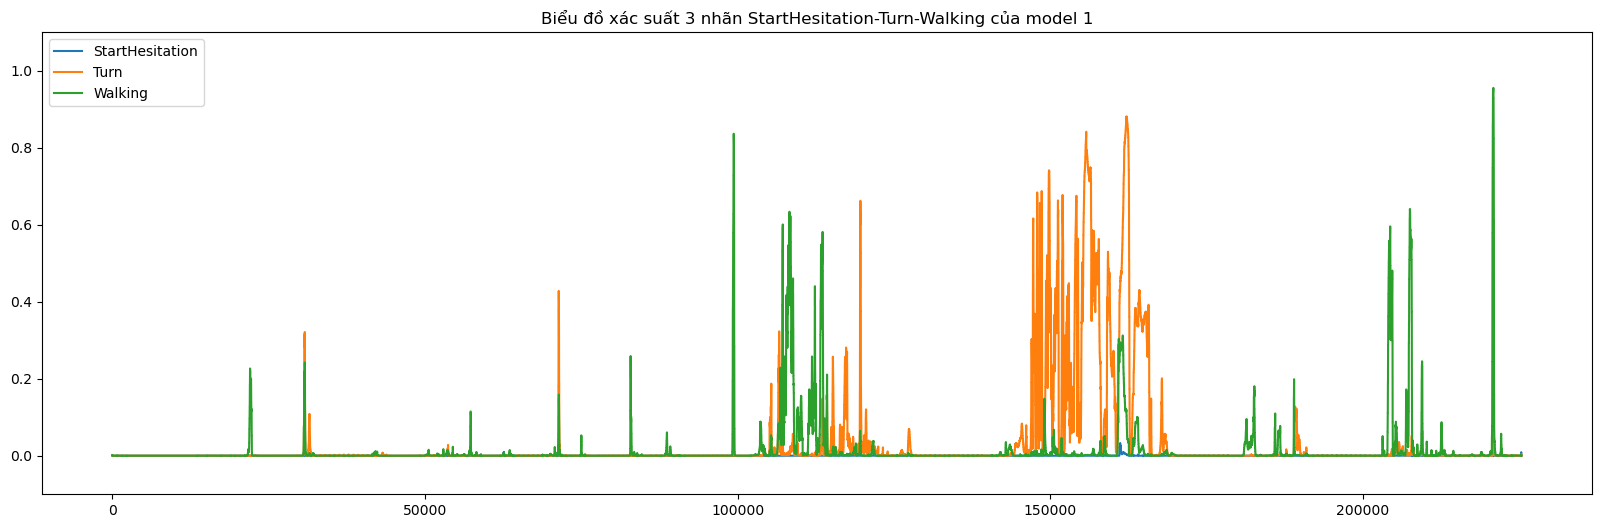

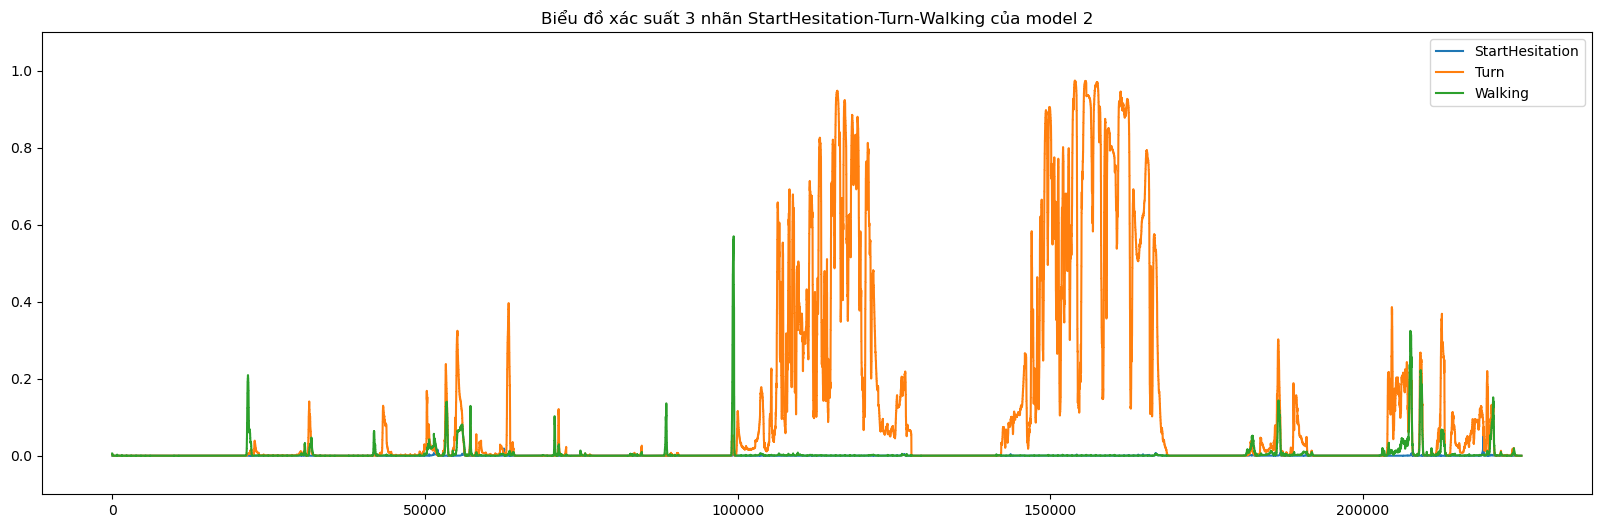

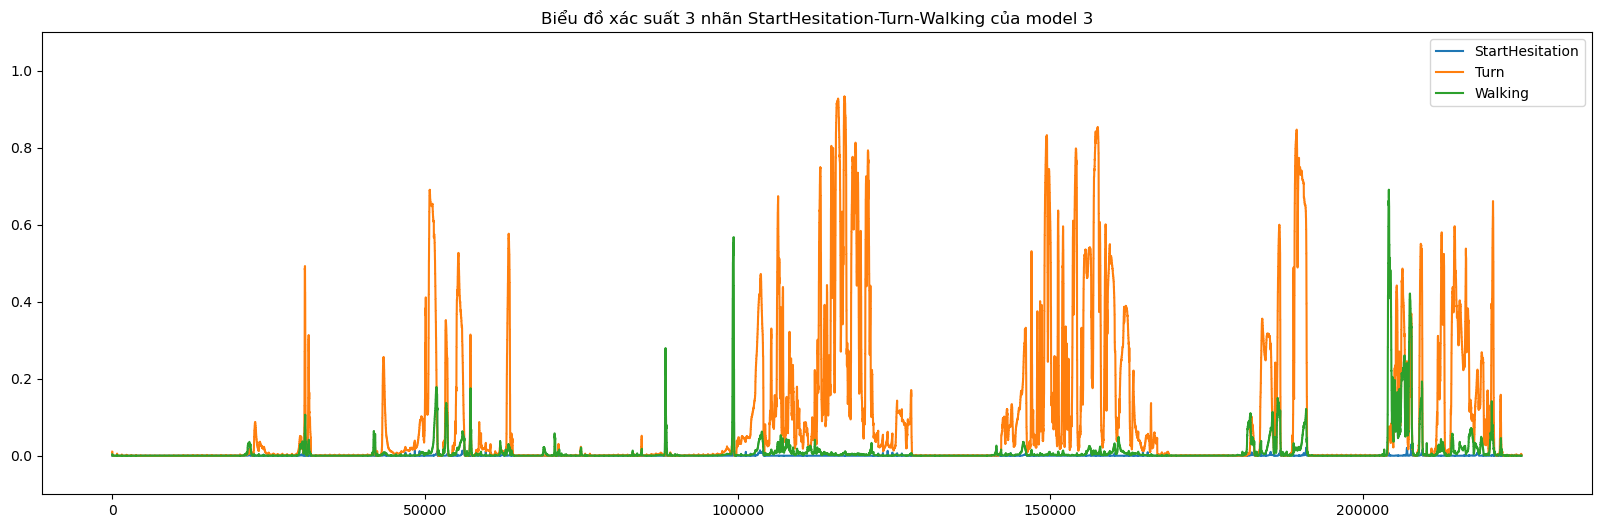

In [10]:
if len(all_submissions) <= 10:
    count = 0
    for series in all_submissions:
        count+=1
        plt.figure(figsize=(20, 6))
        plt.title(f"Biểu đồ xác suất 3 nhãn StartHesitation-Turn-Walking của model {count}")
        plt.plot(series['StartHesitation'], label='StartHesitation')
        plt.plot(series['Turn'], label='Turn')
        plt.plot(series['Walking'], label='Walking')
        plt.ylim([-0.1, 1.1])
        plt.legend()
        plt.show()

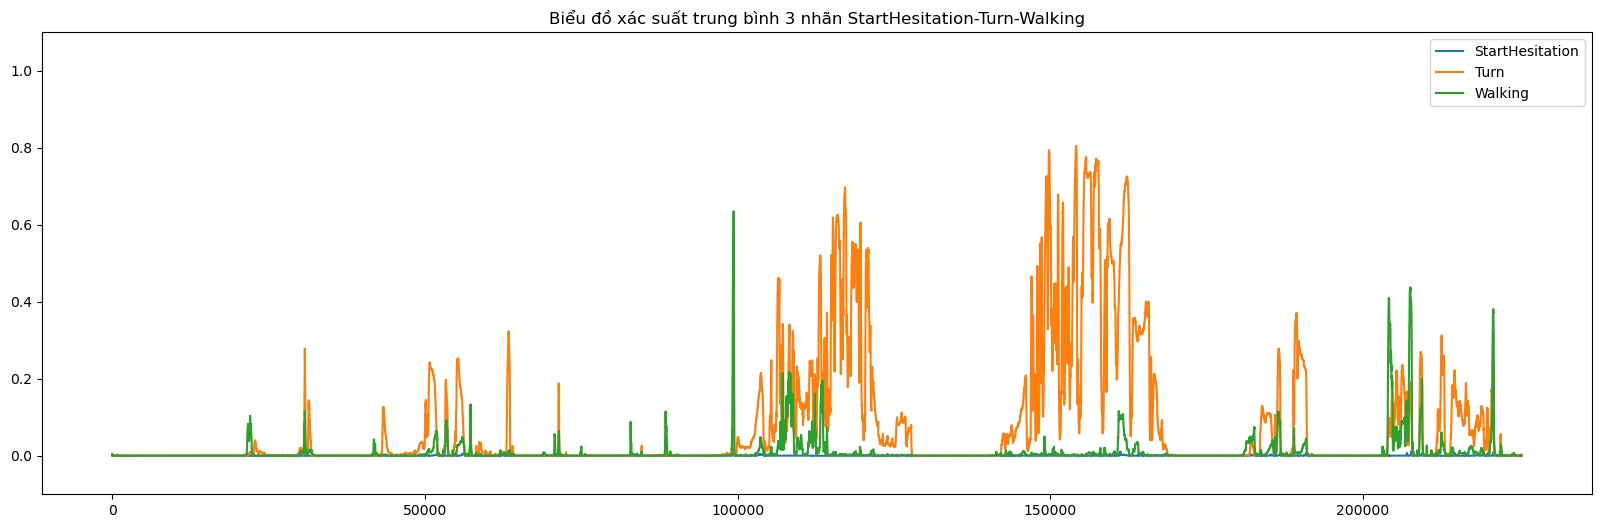

In [11]:
plt.figure(figsize=(20, 6))
plt.title(f"Biểu đồ xác suất trung bình 3 nhãn StartHesitation-Turn-Walking")
plt.plot(mean_sub['StartHesitation'], label='StartHesitation')
plt.plot(mean_sub['Turn'], label='Turn')
plt.plot(mean_sub['Walking'], label='Walking')
plt.ylim([-0.1, 1.1])
plt.legend()
plt.show()

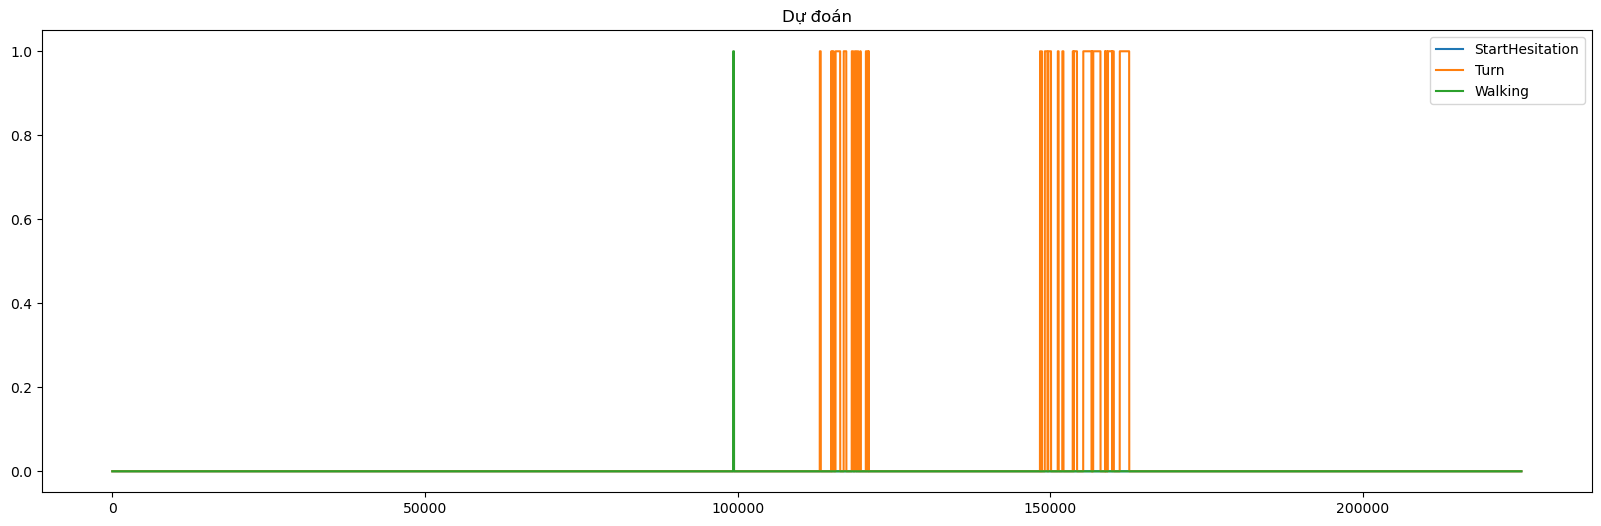

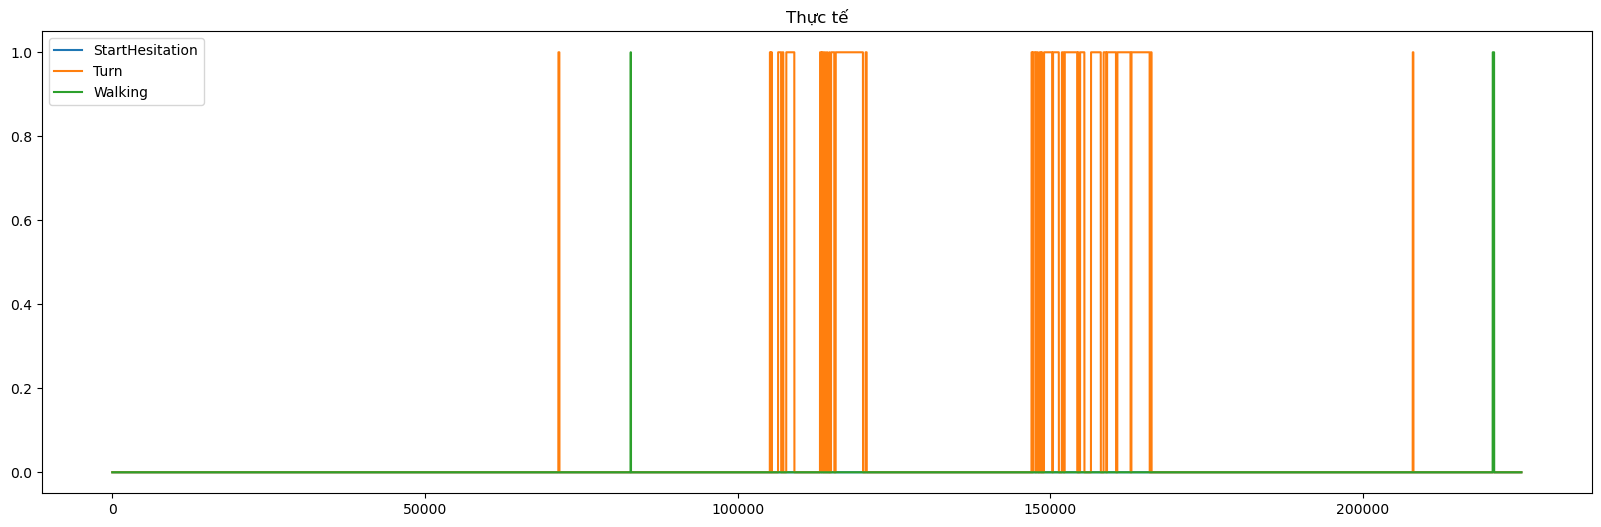

In [12]:
mean_sub_0_1 = mean_sub.applymap(lambda x: 1 if x >= 0.5 else 0)
y_true = pd.read_csv("/kaggle/input/test-data/1ff78d55e9.csv").iloc[:,-3:]
y_pred = mean_sub_0_1
plt.figure(figsize=(20, 6))
plt.title("Dự đoán")
plt.plot(y_pred['StartHesitation'], label='StartHesitation')
plt.plot(y_pred['Turn'], label='Turn')
plt.plot(y_pred['Walking'], label='Walking')
plt.legend()
plt.figure(figsize=(20, 6))
plt.plot(y_true['StartHesitation'], label='StartHesitation')
plt.plot(y_true['Turn'], label='Turn')
plt.plot(y_true['Walking'], label='Walking')
plt.title("Thực tế")
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import average_precision_score, accuracy_score, f1_score


# Tính average precision
StartHesitationAP = average_precision_score(y_true['StartHesitation'], y_pred['StartHesitation'])
TurnAP = average_precision_score(y_true['Turn'], y_pred['Turn'])
WalkingAP = average_precision_score(y_true['Walking'], y_pred['Walking'])
print(f'StartHesitationAP: {StartHesitationAP}')
print(f'TurnAP: {TurnAP}')
print(f'WalkingAP: {WalkingAP}')

acc = accuracy_score(y_true, y_pred)
print(f'Accuracy: {acc}')
f1 = f1_score(y_true, y_pred, average='micro')
print(f'F1 score: {f1}')

StartHesitationAP: -0.0
TurnAP: 0.37426769870647364
WalkingAP: 0.0012427101733580692
Accuracy: 0.9269996538164517
F1 score: 0.49908636861980754
